# Descargar el Dataset de kaggle 
(No volver a descargar, ya está en la carpeta data/chestxray del proyecto)

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [03:51<00:00, 195MB/s] 


Extracting files...
Path to dataset files: /home/project_cv_um/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


La celda de abajo mueve los archivos de la carpeta del cache de kagglehub a la carpeta del proyecto. 
En la instancia de Google Cloud los datos son persistentes, no es necesario bajarlos de GDrive.

In [8]:

from pathlib import Path
import shutil
from tqdm.notebook import tqdm

src = Path(path)
dst = Path("./data/chestxray")

dst.mkdir(parents=True, exist_ok=True)

items = list(src.iterdir())
for p in tqdm(items, desc="Moviendo archivos"):
    target = dst / p.name
    try:
        # mover archivo o carpeta
        shutil.move(str(p), str(target))
    except Exception as e:
        print(f"Error moviendo {p}: {e}")


Moviendo archivos:   0%|          | 0/20 [00:00<?, ?it/s]

# imports necesarios y verificación de la carpeta con el dataset

In [1]:

from pathlib import Path
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


data_path = Path("./data/chestxray")


print("Data encontrada:", data_path.exists())

Data encontrada: True


# Preparación Entorno

Esta celda carga las clases de python locales

In [2]:
code_dir = (Path.cwd() / "code").resolve()
print("code_dir:", code_dir)
if not code_dir.exists():
    raise FileNotFoundError(f"No existe la carpeta {code_dir}")

if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))
    print("Añadido a sys.path")

# listar archivos relevantes
for p in sorted(code_dir.iterdir()):
    print("-", p.name)
from genCSVMap import prepare_labels_dataset

code_dir: /home/project_cv_um/ProyectoCNN/code
Añadido a sys.path
- .ipynb_checkpoints
- CNNTransformerFusion.py
- __pycache__
- datasetMgr.py
- genCSVMap.py


In [3]:
df = pd.read_csv(data_path / "Data_Entry_2017.csv")
print(df.head())

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [4]:
labels_df, train_val_df, test_df = prepare_labels_dataset(
    base_path='./data/chestxray'
)


labels train size: 86524  |  labels test size: 25596


One-hot encoding diseases: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.66it/s]


Buscando imágenes en subcarpetas (extensiones png/jpg/jpeg) ...
112120 archivos de imágenes encontrados en la estructura de carpetas.


Resolviendo paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112120/112120 [00:05<00:00, 19955.11it/s]


Resolución: 112120 encontrados, 0 no encontrados.
0 entradas con múltiples candidatos (usa 'All_Paths' para ver opciones).
Dataset procesado guardado en: ./data/chestxray/IdxDataset.csv
Train/Val (marcados): 86524 imágenes
Test (marcados): 25596 imágenes
Total filas en processed_df (sin eliminar): 112120

Ejemplo (primeras 5 filas de processed_df):
        Image_Index                                               Path  \
0  00000001_000.png  data/chestxray/images_001/images/00000001_000.png   
1  00000001_001.png  data/chestxray/images_001/images/00000001_001.png   
2  00000001_002.png  data/chestxray/images_001/images/00000001_002.png   
3  00000002_000.png  data/chestxray/images_001/images/00000002_000.png   
4  00000003_000.png  data/chestxray/images_001/images/00000003_000.png   

                                           All_Paths  Num_Candidates  \
0  [data/chestxray/images_001/images/00000001_000...               1   
1  [data/chestxray/images_001/images/00000001_001...        

In [5]:
labels_df.columns

Index(['Image_Index', 'Path', 'All_Paths', 'Num_Candidates', 'Missing_Path',
       'Patient_Age', 'Gender_Code', 'View_Code', 'Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'in_train_val', 'in_test'],
      dtype='object')

In [5]:

train_df, val_df = train_test_split( train_val_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)} imágenes")
print(f"Val:   {len(val_df)} imágenes")
print(f"Test:  {len(test_df)} imágenes")

Train: 69219 imágenes
Val:   17305 imágenes
Test:  25596 imágenes


# Transforming

In [6]:
DISEASE_COLUMNS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
from datasetMgr import datasetMgr

train_dataset = datasetMgr(dataframe=train_df,disease_columns=DISEASE_COLUMNS,transform=train_transform)
val_dataset = datasetMgr(dataframe=val_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)
test_dataset = datasetMgr(dataframe=test_df,disease_columns=DISEASE_COLUMNS,transform=val_transform)

print(f"Train dataset: {len(train_dataset)} muestras")
print(f"Val dataset:   {len(val_dataset)} muestras")
print(f"Test dataset:  {len(test_dataset)} muestras")


Train dataset: 69219 muestras
Val dataset:   17305 muestras
Test dataset:  25596 muestras


## Dataloader

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = 7 #vCPU -1

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,prefetch_factor=4)

print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

   Train batches: 1082
   Val batches:   271
   Test batches:  400


### Dataloaders Creados

In [9]:
images, meta, labels = next(iter(train_loader))

print(f"\nBatch de entrenamiento:")
print(f"Imágenes shape: {images.shape}")      # Debe ser (32, 3, 224, 224) para ser compatible por RESNET
print(f"Labels shape:   {labels.shape}")      # Debe ser (32, 14) IDEM
print(f"Imágenes - Min: {images.min():.3f}, Max: {images.max():.3f}")
print(f"Labels - Min:   {labels.min():.0f}, Max: {labels.max():.0f}")


print(f"\n  Labels por enfermedad en este batch:")
for i, disease in enumerate(DISEASE_COLUMNS):
    count = labels[:, i].sum().item()
    print(f"    {disease:20s}: {count:.0f}/{BATCH_SIZE}")


Batch de entrenamiento:
Imágenes shape: torch.Size([64, 3, 224, 224])
Labels shape:   torch.Size([64, 14])
Imágenes - Min: -2.118, Max: 2.640
Labels - Min:   0, Max: 1

  Labels por enfermedad en este batch:
    Atelectasis         : 6/64
    Consolidation       : 1/64
    Infiltration        : 9/64
    Pneumothorax        : 3/64
    Edema               : 0/64
    Emphysema           : 4/64
    Fibrosis            : 0/64
    Effusion            : 10/64
    Pneumonia           : 2/64
    Pleural_Thickening  : 2/64
    Cardiomegaly        : 2/64
    Nodule              : 7/64
    Mass                : 2/64
    Hernia              : 0/64



Visualizando imágenes de ejemplo...


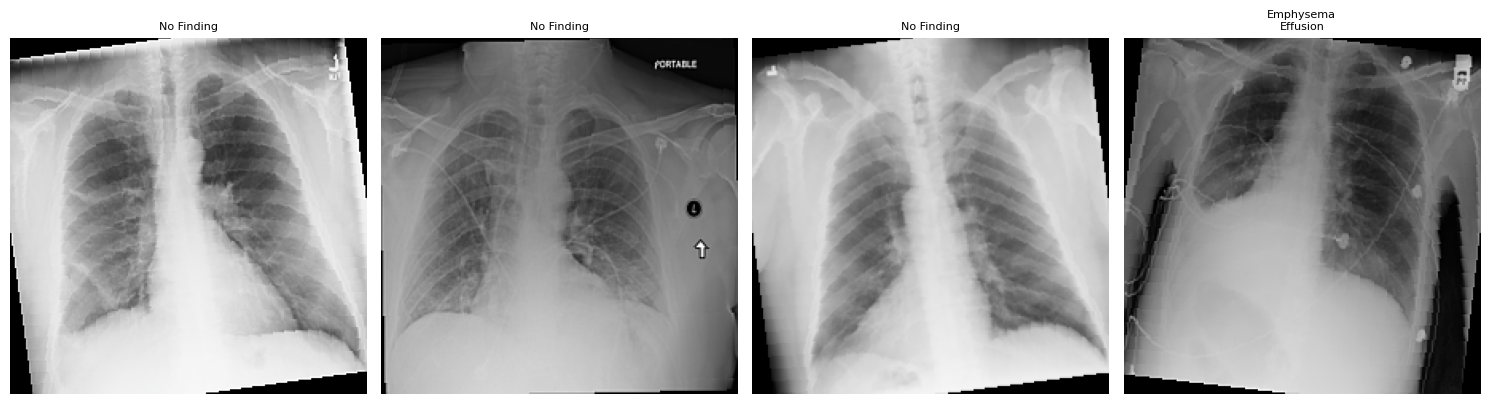

In [10]:

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(images, labels, n=4):
    fig, axes = plt.subplots(1, n, figsize=(15, 4))

    for i in range(n):
        img = denormalize(images[i].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        diseases = [DISEASE_COLUMNS[j] for j in range(14) if labels[i, j] == 1]
        diseases_str = '\n'.join(diseases[:3]) if diseases else 'No Finding'

        axes[i].imshow(img)
        axes[i].set_title(diseases_str, fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizando imágenes de ejemplo...")
show_batch(images, labels, n=4)

In [18]:
len(DISEASE_COLUMNS)

14

## Transfer Learning

In [11]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
num_classes = len(DISEASE_COLUMNS)

Usando dispositivo: cuda


### DenseNet121

Entrena los epochs hasta 100. En cada iteración corre un epoch de validación y toma el epoch con mejor val_mean_auc.
Si no mejora en 3 iteraciones, baja el learning rate en cada iteracion hasta la nro 8.
Cuando pasan 8 iteraciones sin mejoras deja de entrenar. 

In [14]:
from CNNTransformerFusion import CNNTransformerFusion
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import time
import copy



num_epochs = 100                # valor alto inicial, converge mucho antes
patience = 8                    # early stopping patience, determina cuantas iteraciones más hace luego de que no mejora más
best_metric = -np.inf           # monitorizando AUC mayor es mejor; 

model = CNNTransformerFusion(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# -----------------------------
# Calcular pos_weight desde train_loader (Opción 1)
# -----------------------------
# número de clases (ya lo tenés en num_classes)
pos_counts = np.zeros(num_classes, dtype=np.float64)
total_samples = 0

# Recorremos train_loader para contar positivos por clase
# (esto no afecta el DataLoader para el entrenamiento posterior)
print("Computando pos_weight a partir de train_loader (conteo de positivos por clase)...")
for _, _, lbls in train_loader:
    # lbls puede venir como tensor en CPU/GPU; pasar a numpy en CPU
    if isinstance(lbls, torch.Tensor):
        lbls_np = lbls.cpu().numpy()
    else:
        lbls_np = np.array(lbls)
    pos_counts += lbls_np.sum(axis=0)
    total_samples += lbls_np.shape[0]

neg_counts = total_samples - pos_counts
# evitar division por cero y pesos extremadamente grandes
eps = 1e-6
raw_pos_weight = neg_counts / (pos_counts + eps)

# opcional: limitar máximo de pos_weight para estabilidad
max_weight = 100.0
pos_weight_clipped = np.minimum(raw_pos_weight, max_weight)

pos_weight_tensor = torch.tensor(pos_weight_clipped, dtype=torch.float32).to(device)
print("total_samples:", total_samples)
print("positives per class:", pos_counts.astype(int))
print("raw pos_weight:", np.round(raw_pos_weight, 3))
print("clipped pos_weight:", np.round(pos_weight_clipped, 3))

# Crear criterion ponderada
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
# -----------------------------

Computando pos_weight a partir de train_loader (conteo de positivos por clase)...
total_samples: 69219
positives per class: [ 6575  2244 11034  2098  1122  1127   984  6896   696  1765  1348  3787
  3226   110]
raw pos_weight: [  9.528  29.846   5.273  31.993  60.693  60.419  69.345   9.038  98.453
  38.218  50.349  17.278  20.457 628.264]
clipped pos_weight: [  9.528  29.846   5.273  31.993  60.693  60.419  69.345   9.038  98.453
  38.218  50.349  17.278  20.457 100.   ]


In [ ]:

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                       factor=0.5, patience=3)
# mode='max' porque vamos a monitorizar mean AUC (mayor mejor).

best_state = None
best_epoch = 0
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_mean_auc': []}

def compute_mean_auc(y_true, y_probs):
    aucs = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0 and np.sum(y_true[:, i]) < len(y_true):  # requiere positivos y negativos
            aucs.append(roc_auc_score(y_true[:, i], y_probs[:, i]))
    if len(aucs) == 0:
        return np.nan
    return np.mean(aucs)

for epoch in range(1, num_epochs+1):
    t0 = time.time()
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    for images, meta, labels in train_loader:
        images, meta, labels = images.to(device, non_blocking=True), meta.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images, meta, labels in val_loader:
            images, meta, labels = images.to(device), meta.to(device), labels.to(device)
            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            all_outputs.append(outputs.cpu().sigmoid().numpy())   # convertir logits -> probs
            all_labels.append(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    val_mean_auc = compute_mean_auc(all_labels, all_outputs)
    history['val_mean_auc'].append(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # Scheduler (si usas ReduceLROnPlateau), usa la métrica que desees:
    # Aquí reducimos LR si val_mean_auc no mejora (mode='max' en scheduler)
    scheduler.step(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # ---- Early stopping & checkpoint (monitorizar val_mean_auc) ----
    is_best = (val_mean_auc is not np.nan) and (val_mean_auc > best_metric)
    if is_best:
        best_metric = val_mean_auc
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(best_state, "best_model.pth")
        print(f"Epoch {epoch}: ⭐ New best model (val_mean_auc={val_mean_auc:.4f}) saved.")
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_mean_auc: {val_mean_auc:.4f}  time: {time.time()-t0:.1f}s")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered. No improvement in {patience} epochs.")
        break

print(f"Training finished. Best epoch: {best_epoch} with val_mean_auc={best_metric:.4f}")
# carga el mejor modelo
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1: ⭐ New best model (val_mean_auc=0.7674) saved.
Epoch 1/100 - train_loss: 1.1241  val_loss: 1.0630  val_mean_auc: 0.7674  time: 452.0s
Epoch 2: ⭐ New best model (val_mean_auc=0.7810) saved.
Epoch 2/100 - train_loss: 1.0224  val_loss: 1.0506  val_mean_auc: 0.7810  time: 454.9s
Epoch 3: ⭐ New best model (val_mean_auc=0.8113) saved.
Epoch 3/100 - train_loss: 0.9628  val_loss: 0.9705  val_mean_auc: 0.8113  time: 455.0s
Epoch 4: ⭐ New best model (val_mean_auc=0.8144) saved.
Epoch 4/100 - train_loss: 0.9273  val_loss: 0.9788  val_mean_auc: 0.8144  time: 456.3s
Epoch 5: ⭐ New best model (val_mean_auc=0.8227) saved.
Epoch 5/100 - train_loss: 0.9059  val_loss: 0.9502  val_mean_auc: 0.8227  time: 454.7s
Epoch 6: ⭐ New best model (val_mean_auc=0.8279) saved.
Epoch 6/100 - train_loss: 0.8806  val_loss: 0.9317  val_mean_auc: 0.8279  time: 456.7s
Epoch 7/100 - train_loss: 0.8591  val_loss: 0.9523  val_mean_auc: 0.8266  time: 455.0s
Epoch 8: ⭐ New best model (val_mean_auc=0.8285) saved.
Epoch 

In [15]:
# ---------------- CELDA 1: recrear history y cargar best_model.pth ----------------
import numpy as np
import torch
import copy
from CNNTransformerFusion import CNNTransformerFusion

# --- recreate history from logs (epochs 1..14) ---
history = {
    'train_loss': [
        1.1241, 1.0224, 0.9628, 0.9273, 0.9059, 0.8806, 0.8591,
        0.8390, 0.8104, 0.7913, 0.7657, 0.7519, 0.7326, 0.7027
    ],
    'val_loss': [
        1.0630, 1.0506, 0.9705, 0.9788, 0.9502, 0.9317, 0.9523,
        0.9513, 0.9500, 0.9573, 1.0144, 1.0228, 1.0796, 1.1113
    ],
    'val_mean_auc': [
        0.7674, 0.7810, 0.8113, 0.8144, 0.8227, 0.8279, 0.8266,
        0.8285, 0.8291, 0.8334, 0.8270, 0.8235, 0.8259, 0.8280
    ]
}

# --- control values inferred from logs ---
best_epoch = 10               # último epoch guardado según tus logs
best_metric = 0.8334          # val_mean_auc correspondiente
last_epoch_logged = 14        # hasta dónde había corrido y lo loggeaste

# start epoch = next after the last saved epoch (we load weights from best_epoch)
start_epoch = best_epoch + 1  # => 11

# epochs_no_improve: as we are loading the saved best, reset counter to 0
epochs_no_improve = 0

print(f"History recreated with {len(history['train_loss'])} epochs (logged up to epoch {last_epoch_logged}).")
print("Loading model weights from best_model.pth (assumed to be epoch", best_epoch, "with val_mean_auc=", best_metric, ")")
print("Will resume training from start_epoch =", start_epoch)

# --- instantiate model and load weights from best_model.pth ---
# assumes `num_classes` and `device` exist in the notebook
model = CNNTransformerFusion(num_classes=num_classes).to(device)

best_path = "best_model.pth"
state = torch.load(best_path, map_location=device)
# handle either a state_dict or an entire checkpoint dict
if isinstance(state, dict) and ("model_state_dict" in state) and (len(state.keys()) > 1):
    # checkpoint-like dict
    model.load_state_dict(state["model_state_dict"])
    # if checkpoint contains best_metric/epoch, we can override:
    if "best_metric" in state:
        best_metric = state["best_metric"]
    if "epoch" in state:
        # if you want to update best_epoch from checkpoint, uncomment:
        # best_epoch = state["epoch"]
        pass
else:
    # assume state is a plain state_dict
    model.load_state_dict(state)

model.eval()
print("Model weights loaded from", best_path)

# --- re-create optimizer and scheduler (so training can be resumed) ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# ensure criterion exists (if you used pos_weight earlier, recreate it before running)
try:
    criterion
except NameError:
    criterion = torch.nn.BCEWithLogitsLoss()

# expose variables for the next cell
print("Ready. Variables set: model, optimizer, scheduler, criterion, start_epoch, history, best_metric, best_epoch.")
# -----------------------------------------------------------------------------


History recreated with 14 epochs (logged up to epoch 14).
Loading model weights from best_model.pth (assumed to be epoch 10 with val_mean_auc= 0.8334 )
Will resume training from start_epoch = 11
Model weights loaded from best_model.pth
Ready. Variables set: model, optimizer, scheduler, criterion, start_epoch, history, best_metric, best_epoch.


In [16]:
# ---------------- CELDA 2: reanudar training desde start_epoch ----------------
import time
import numpy as np
import copy
from sklearn.metrics import roc_auc_score

# compute_mean_auc (redefine si no está)
def compute_mean_auc(y_true, y_probs):
    aucs = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0 and np.sum(y_true[:, i]) < len(y_true):
            aucs.append(roc_auc_score(y_true[:, i], y_probs[:, i]))
    if len(aucs) == 0:
        return np.nan
    return np.mean(aucs)

# Ensure history keys exist
history.setdefault('train_loss', [])
history.setdefault('val_loss', [])
history.setdefault('val_mean_auc', [])

# Resume loop
for epoch in range(start_epoch, num_epochs+1):
    t0 = time.time()
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    for images, meta, labels in train_loader:
        images = images.to(device, non_blocking=True)
        meta = meta.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images, meta, labels in val_loader:
            images = images.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            all_outputs.append(outputs.cpu().sigmoid().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    val_mean_auc = compute_mean_auc(all_labels, all_outputs)
    history['val_mean_auc'].append(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # Scheduler step expects the monitored metric
    scheduler.step(val_mean_auc if not np.isnan(val_mean_auc) else 0.0)

    # Early stopping & checkpoint (monitor val_mean_auc)
    is_best = (val_mean_auc is not np.nan) and (val_mean_auc > best_metric)
    if is_best:
        best_metric = val_mean_auc
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(best_state, "best_model.pth")
        print(f"Epoch {epoch}: ⭐ New best model (val_mean_auc={val_mean_auc:.4f}) saved.")
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_mean_auc: {val_mean_auc:.4f}  time: {time.time()-t0:.1f}s")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered. No improvement in {patience} epochs.")
        break

print(f"Training finished. Best epoch: {best_epoch} with val_mean_auc={best_metric:.4f}")

# Cargar el mejor modelo guardado (opcional)
if 'best_state' in locals() and best_state is not None:
    model.load_state_dict(best_state)
    print("Best state loaded into model (from current run).")
else:
    # If we didn't improve, we still have the previous best_model.pth file loaded
    print("No new best found in this run; current model kept as-is (weights loaded from best_model.pth before resume).")
# -----------------------------------------------------------------------------


Epoch 11: ⭐ New best model (val_mean_auc=0.8341) saved.
Epoch 11/100 - train_loss: 0.7637  val_loss: 0.9720  val_mean_auc: 0.8341  time: 430.9s
Epoch 12/100 - train_loss: 0.7395  val_loss: 1.0244  val_mean_auc: 0.8321  time: 431.4s
Epoch 13/100 - train_loss: 0.7208  val_loss: 1.0235  val_mean_auc: 0.8289  time: 432.4s
Epoch 14/100 - train_loss: 0.6998  val_loss: 1.0258  val_mean_auc: 0.8320  time: 428.8s
Epoch 15/100 - train_loss: 0.6728  val_loss: 1.0994  val_mean_auc: 0.8241  time: 436.1s
Epoch 16/100 - train_loss: 0.6006  val_loss: 1.2215  val_mean_auc: 0.8260  time: 433.5s
Epoch 17/100 - train_loss: 0.5650  val_loss: 1.2938  val_mean_auc: 0.8267  time: 429.7s
Epoch 18/100 - train_loss: 0.5403  val_loss: 1.3028  val_mean_auc: 0.8223  time: 429.4s
Epoch 19/100 - train_loss: 0.5237  val_loss: 1.3611  val_mean_auc: 0.8232  time: 434.4s
Early stopping triggered. No improvement in 8 epochs.
Training finished. Best epoch: 11 with val_mean_auc=0.8341
Best state loaded into model (from curr

In [17]:
from sklearn.metrics import roc_curve
thresholds = []
for i in range(num_classes):
    y_true = all_labels[:, i]
    y_prob = 1 / (1 + np.exp(-all_outputs[:, i]))
    if np.sum(y_true) > 0:
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        j_scores = tpr - fpr
        best_t = thr[np.argmax(j_scores)]
        thresholds.append(best_t)
    else:
        thresholds.append(0.5)
print("Thresholds óptimos por clase:", np.round(thresholds, 3))


Thresholds óptimos por clase: [0.617 0.632 0.621 0.596 0.505 0.544 0.509 0.624 0.587 0.593 0.51  0.615
 0.592 0.501]


# Cargar modelo

In [12]:
# ------------------- CELDA: LOAD BEST MODEL -------------------
import torch
from CNNTransformerFusion import CNNTransformerFusion

# Debe ser el mismo número de clases y el mismo device que usaste al entrenar
model = CNNTransformerFusion(num_classes=num_classes).to(device)

# Cargar pesos guardados en entrenamiento
state = torch.load("best_model.pth", map_location=device)

model.load_state_dict(state)
model.eval()   # modo inferencia

print("Modelo cargado correctamente desde best_model.pth")
# ---------------------------------------------------------------


Modelo cargado correctamente desde best_model.pth


In [21]:
# ---- CELDA PARA REEMPLAZAR HISTORY DESDE EPOCH 11 AL 19 ----
history = {
    'train_loss': [
        1.1241, 1.0224, 0.9628, 0.9273, 0.9059, 0.8806, 0.8591,
        0.8390, 0.8104, 0.7913, 0.7657, 0.7519, 0.7326, 0.7027
    ],
    'val_loss': [
        1.0630, 1.0506, 0.9705, 0.9788, 0.9502, 0.9317, 0.9523,
        0.9513, 0.9500, 0.9573, 1.0144, 1.0228, 1.0796, 1.1113
    ],
    'val_mean_auc': [
        0.7674, 0.7810, 0.8113, 0.8144, 0.8227, 0.8279, 0.8266,
        0.8285, 0.8291, 0.8334, 0.8270, 0.8235, 0.8259, 0.8280
    ]
}
# Nuevos valores (ya organizados)
new_train_loss = [0.7637, 0.7395, 0.7208, 0.6998, 0.6728, 0.6006, 0.5650, 0.5403, 0.5237]
new_val_loss = [0.9720, 1.0244, 1.0235, 1.0258, 1.0994, 1.2215, 1.2938, 1.3028, 1.3611]
new_val_mean_auc = [0.8341, 0.8321, 0.8289, 0.8320, 0.8241, 0.8260, 0.8267, 0.8223, 0.8232]

# Reemplazar en la historia (posiciones 10 a 18)
start = 10  # epoch 11 (index 10)
end = start + len(new_train_loss)

history["train_loss"][start:end] = new_train_loss
history["val_loss"][start:end] = new_val_loss
history["val_mean_auc"][start:end] = new_val_mean_auc

print("History actualizado:")
for k, v in history.items():
    print(k, "→", len(v), "valores")


History actualizado:
train_loss → 19 valores
val_loss → 19 valores
val_mean_auc → 19 valores


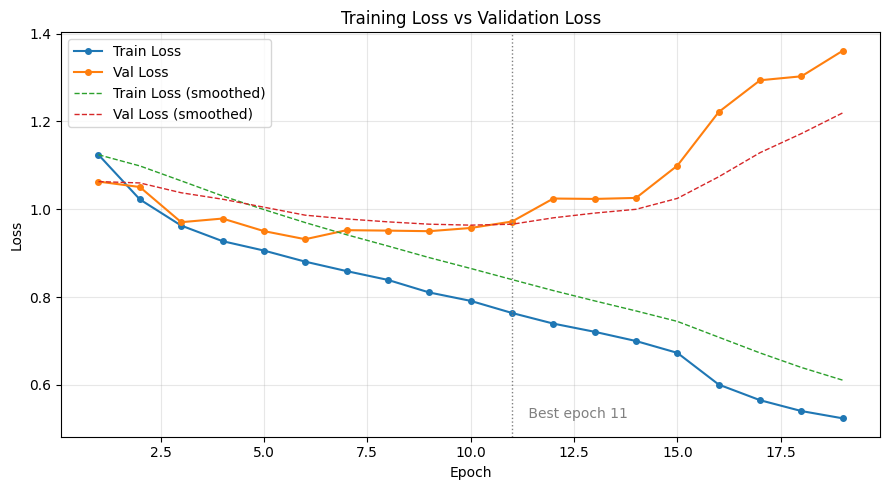

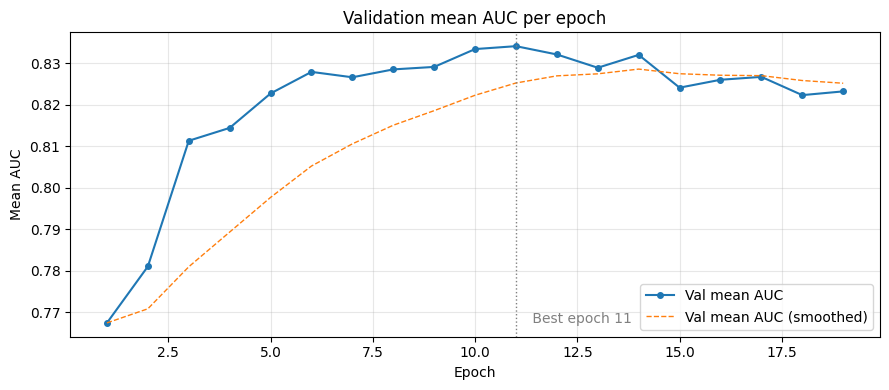

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer y convertir a numpy arrays (seguro contra listas)
train_losses = np.array(history['train_loss'], dtype=float)
val_losses = np.array(history['val_loss'], dtype=float)
val_mean_auc = np.array(history['val_mean_auc'], dtype=float)

epochs = np.arange(1, len(train_losses) + 1)

# ----- Función de suavizado (EMA) -----
def smooth(x, alpha=0.3):
    if len(x) == 0:
        return x
    out = [x[0]]
    for v in x[1:]:
        out.append(alpha * v + (1 - alpha) * out[-1])
    return np.array(out)

# ----- Plot Loss -----
plt.figure(figsize=(9,5))
plt.plot(epochs, train_losses, label='Train Loss', linewidth=1.5, marker='o', markersize=4)
plt.plot(epochs, val_losses, label='Val Loss', linewidth=1.5, marker='o', markersize=4)

# suavizado (opcional)
plt.plot(epochs, smooth(train_losses, alpha=0.25), label='Train Loss (smoothed)', linestyle='--', linewidth=1)
plt.plot(epochs, smooth(val_losses, alpha=0.25), label='Val Loss (smoothed)', linestyle='--', linewidth=1)

# marcar mejor epoch (si existe y está en rango)
if best_epoch and 1 <= best_epoch <= len(epochs):
    plt.axvline(best_epoch, color='gray', linestyle=':', linewidth=1)
    # calcular un y para la etiqueta de texto sin errores si todo es nan
    try:
        min_y = float(np.nanmin(np.concatenate([train_losses[~np.isnan(train_losses)], 
                                                val_losses[~np.isnan(val_losses)]])))
    except ValueError:
        # si todo es NaN (raro), usar 0
        min_y = 0.0
    plt.text(best_epoch + 0.3, min_y, f' Best epoch {best_epoch}', color='gray')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Plot Val Mean AUC (si quieres) -----
plt.figure(figsize=(9,4))
plt.plot(epochs, val_mean_auc, label='Val mean AUC', linewidth=1.5, marker='o', markersize=4)
plt.plot(epochs, smooth(val_mean_auc, alpha=0.25), label='Val mean AUC (smoothed)', linestyle='--', linewidth=1)

if best_epoch and 1 <= best_epoch <= len(epochs):
    plt.axvline(best_epoch, color='gray', linestyle=':', linewidth=1)
    # para la posición vertical del texto, elegir el mínimo finito
    finite_mask = np.isfinite(val_mean_auc)
    if finite_mask.any():
        y_text = float(np.nanmin(val_mean_auc[finite_mask]))
    else:
        y_text = 0.0
    plt.text(best_epoch + 0.3, y_text, f' Best epoch {best_epoch}', color='gray')

plt.xlabel('Epoch')
plt.ylabel('Mean AUC')
plt.title('Validation mean AUC per epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Evaluacion DenseNet121

In [23]:

model.eval()
total_loss = 0.0
all_outputs = []
all_labels = []


with torch.no_grad():
    for images, meta, labels in tqdm(test_loader, desc="Evaluando"):
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        
        # Recopilar outputs y labels para AUC
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todos los outputs y labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Test Loss: {total_loss / len(test_loader.dataset):.4f}")

Evaluando: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:58<00:00,  3.38it/s]

Test Loss: 1.4316


#### Evaluación AUC

In [24]:
try:
    auc_scores = []
    for i in range(num_classes):
        if np.sum(all_labels[:, i]) > 0:
            # Aplicar sigmoid para convertir logits a probabilidades
            probs = 1 / (1 + np.exp(-all_outputs[:, i]))
            auc = roc_auc_score(all_labels[:, i], probs)
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    mean_auc = np.nanmean(auc_scores)
    print(f"\nAUC promedio: {mean_auc:.4f}")
    print("AUC por clase:", np.round(auc_scores, 3))
except Exception as e:
    print("Error al calcular AUC:", e)


AUC promedio: 0.7927
AUC por clase: [0.758 0.731 0.689 0.846 0.822 0.902 0.801 0.812 0.681 0.749 0.875 0.737
 0.802 0.893]


Saved confusion matrices figure to confusion_all_classes.png


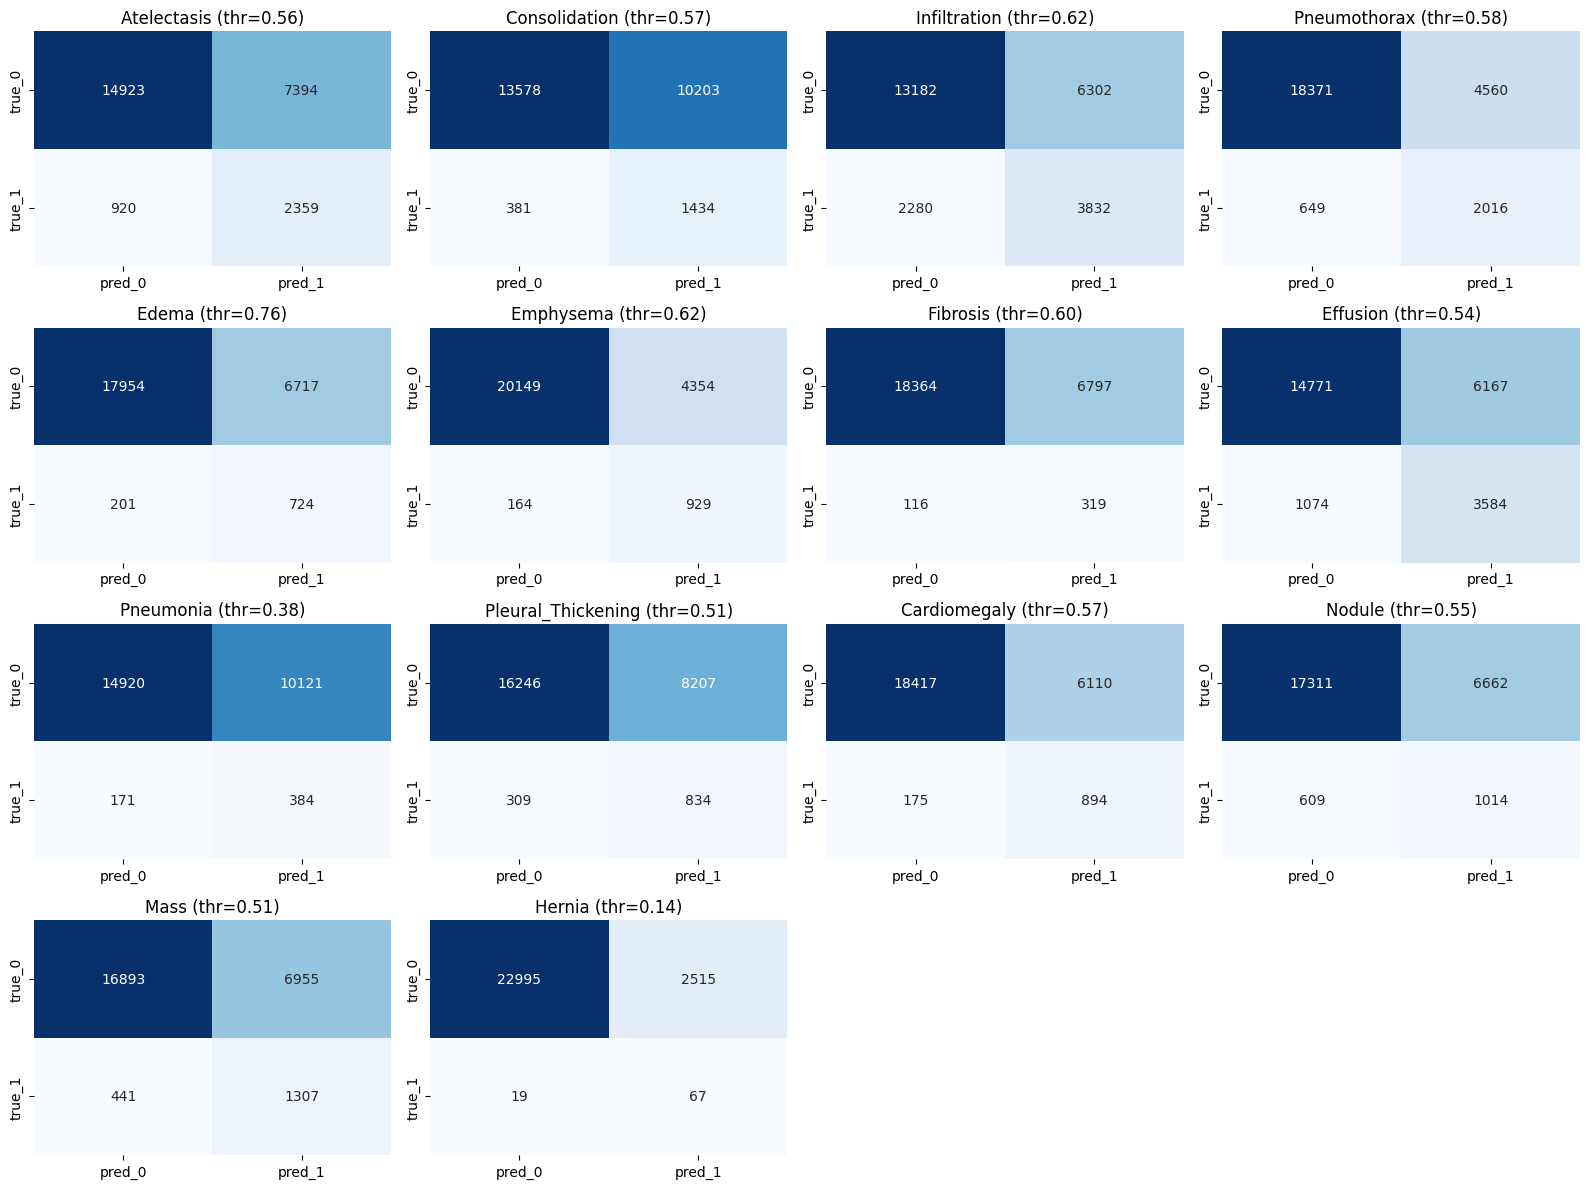

class  threshold    TP     FP    FN     TN  accuracy  \
0             Effusion   0.541010  3584   6167  1074  14771  0.717104   
1         Infiltration   0.620750  3832   6302  2280  13182  0.664713   
2         Pneumothorax   0.584446  2016   4560   649  18371  0.796492   
3          Atelectasis   0.562645  2359   7394   920  14923  0.675184   
4            Emphysema   0.622237   929   4354   164  20149  0.823488   
5                 Mass   0.506491  1307   6955   441  16893  0.711049   
6         Cardiomegaly   0.569938   894   6110   175  18417  0.754454   
7               Nodule   0.549811  1014   6662   609  17311  0.715932   
8        Consolidation   0.574084  1434  10203   381  13578  0.586498   
9                Edema   0.757107   724   6717   201  17954  0.729723   
10  Pleural_Thickening   0.511218   834   8207   309  16246  0.667292   
11            Fibrosis   0.596781   319   6797   116  18364  0.729919   
12           Pneumonia   0.380082   384  10121   171  14920  0.597906   
13              Hernia   0.139922    67   2515    19  22995  0.901000   

    precision    recall        f1  
0    0.367552  0.769429  0.497467  
1    0.378133  0.626963  0.471747  
2    0.306569  0.756473  0.436316  
3    0.241874  0.719427  0.362032  
4    0.175847  0.849954  0.291405  
5    0.158194  0.747712  0.261139  
6    0.127641  0.836296  0.221479  
7    0.132100  0.624769  0.218088  
8    0.123228  0.790083  0.213202  
9    0.097299  0.782703  0.173082  
10   0.092246  0.729659  0.163786  
11   0.044829  0.733333  0.084492  
12   0.036554  0.691892  0.069439  
13   0.025949  0.779070  0.050225

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve

def get_optimal_threshold(y_true, y_probs):
    """Devuelve threshold que maximiza TPR - FPR (Youden index)."""
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        youden = tpr - fpr
        best_idx = np.nanargmax(youden)
        return thresholds[best_idx]
    except Exception:
        return 0.5

def plot_confusion_matrices(
    all_outputs,      # shape (N, num_classes) logits OR probs
    all_labels,       # shape (N, num_classes) 0/1
    class_names=None, # list of class names length=num_classes
    threshold=0.5,
    find_best_threshold=False,
    ncols=4,
    figsize_per_plot=(4,3),
    savepath=None
):
    """
    Dibuja una matriz de confusión por clase para problema multi-label.
    - all_outputs: logits OR probabilities. Si son logits, conviértelos a probs antes (sigmoid).
    - find_best_threshold: si True calcula threshold óptimo por clase (Youden).
    """
    # convert to numpy arrays
    probs = np.array(all_outputs, dtype=float)
    labels = np.array(all_labels, dtype=int)
    if probs.ndim != 2 or labels.ndim != 2:
        raise ValueError("all_outputs y all_labels deben ser arrays 2D (N x num_classes).")

    # Si son logits (valores fuera de [0,1]) aplica sigmoid
    if probs.min() < 0.0 or probs.max() > 1.0:
        probs = 1.0 / (1.0 + np.exp(-probs))  # sigmoid

    N, num_classes = probs.shape
    if class_names is None:
        class_names = [f"class_{i}" for i in range(num_classes)]
    assert len(class_names) == num_classes

    # thresholds por clase
    thresholds = np.full(num_classes, threshold, dtype=float)
    if find_best_threshold:
        for i in range(num_classes):
            # si no hay positivos/negativos suficiente, conservar 0.5
            if np.sum(labels[:, i]) > 0 and np.sum(labels[:, i]) < N:
                thresholds[i] = get_optimal_threshold(labels[:, i], probs[:, i])
            else:
                thresholds[i] = threshold

    # decisiones binarias por clase
    preds = (probs >= thresholds[np.newaxis, :]).astype(int)

    # Preparar grid de plots
    ncols = int(ncols)
    nrows = int(np.ceil(num_classes / ncols))
    fig_w = ncols * figsize_per_plot[0]
    fig_h = nrows * figsize_per_plot[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
    axes = axes.flatten() if num_classes > 1 else [axes]

    # Recolectar summary
    summary = []

    for i in range(num_classes):
        ax = axes[i]
        y_true = labels[:, i]
        y_pred = preds[:, i]

        # si no hay positivos ni negativos, saltear
        if np.sum(y_true) == 0:
            tn = fp = fn = tp = 0
            cm = np.array([[0, 0],[0, 0]])
        else:
            cm = confusion_matrix(y_true, y_pred, labels=[0,1])
            # confusion_matrix retorna [[tn, fp], [fn, tp]]
            tn, fp, fn, tp = cm.ravel()

        # métricas seguras (evitar division por 0)
        acc = accuracy_score(y_true, y_pred) if (np.sum(y_true) + np.sum(~y_true.astype(bool)) > 0) else np.nan
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        summary.append({
            "class": class_names[i],
            "threshold": float(thresholds[i]),
            "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
            "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)
        })

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["pred_0","pred_1"], yticklabels=["true_0","true_1"])
        ax.set_title(f"{class_names[i]} (thr={thresholds[i]:.2f})")
        ax.set_ylabel("")  # opcional
        ax.set_xlabel("")  # opcional

    # ocultar ejes sobrantes
    for j in range(num_classes, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
        print(f"Saved confusion matrices figure to {savepath}")
    plt.show()

    # imprimir resumen ordenado por f1 (u otra métrica)
    import pandas as pd
    df_sum = pd.DataFrame(summary)
    df_sum = df_sum.sort_values(by='f1', ascending=False).reset_index(drop=True)
    display(df_sum)
    return df_sum, preds, thresholds

# ---------------------------
# EJEMPLO de uso:
# ---------------------------
# class_names: lista con nombres de las enfermedades
class_names = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]
df_summary, preds, thresholds = plot_confusion_matrices(all_outputs, all_labels, class_names=class_names, find_best_threshold=True, ncols=4, savepath="confusion_all_classes.png")
#
# O usando threshold fijo 0.5:
# df_summary, preds, thresholds = plot_confusion_matrices(all_outputs, all_labels, class_names=class_names, threshold=0.5, find_best_threshold=False)


Thresholds por clase (usados):
 - Atelectasis: 0.563
 - Consolidation: 0.574
 - Infiltration: 0.621
 - Pneumothorax: 0.584
 - Edema: 0.757
 - Emphysema: 0.622
 - Fibrosis: 0.597
 - Effusion: 0.541
 - Pneumonia: 0.380
 - Pleural_Thickening: 0.511
 - Cardiomegaly: 0.570
 - Nodule: 0.550
 - Mass: 0.506
 - Hernia: 0.140

Resumen global de samples:
 - Total samples: 25596
 - Samples sin patología en GT (all zeros): 9861 (38.53%)
 - Samples donde modelo no predijo ninguna clase: 2665 (10.41%)
 - Entre imágenes enfermas, misses (no_pred & tiene GT>0): 488 (3.10%)


class  threshold    TP     FP    FN     TN  positives_gt  \
11              Nodule   0.549811  1014   6662   609  17311          1623   
2         Infiltration   0.620750  3832   6302  2280  13182          6112   
8            Pneumonia   0.380082   384  10121   171  14920           555   
0          Atelectasis   0.562645  2359   7394   920  14923          3279   
9   Pleural_Thickening   0.511218   834   8207   309  16246          1143   
6             Fibrosis   0.596781   319   6797   116  18364           435   
12                Mass   0.506491  1307   6955   441  16893          1748   
3         Pneumothorax   0.584446  2016   4560   649  18371          2665   
7             Effusion   0.541010  3584   6167  1074  14771          4658   
13              Hernia   0.139922    67   2515    19  22995            86   
4                Edema   0.757107   724   6717   201  17954           925   
1        Consolidation   0.574084  1434  10203   381  13578          1815   
10        Cardiomegaly   0.569938   894   6110   175  18417          1069   
5            Emphysema   0.622237   929   4354   164  20149          1093   

    precision    recall        f1  accuracy  miss_rate_pct  
11   0.132100  0.624769  0.218088  0.715932      37.523105  
2    0.378133  0.626963  0.471747  0.664713      37.303665  
8    0.036554  0.691892  0.069439  0.597906      30.810811  
0    0.241874  0.719427  0.362032  0.675184      28.057335  
9    0.092246  0.729659  0.163786  0.667292      27.034121  
6    0.044829  0.733333  0.084492  0.729919      26.666667  
12   0.158194  0.747712  0.261139  0.711049      25.228833  
3    0.306569  0.756473  0.436316  0.796492      24.352720  
7    0.367552  0.769429  0.497467  0.717104      23.057106  
13   0.025949  0.779070  0.050225  0.901000      22.093023  
4    0.097299  0.782703  0.173082  0.729723      21.729730  
1    0.123228  0.790083  0.213202  0.586498      20.991736  
10   0.127641  0.836296  0.221479  0.754454      16.370440  
5    0.175847  0.849954  0.291405  0.823488      15.004575


Per-class summary saved to eval_outputs_per_class_summary.csv
Saved histograms to eval_outputs_prob_histograms.png


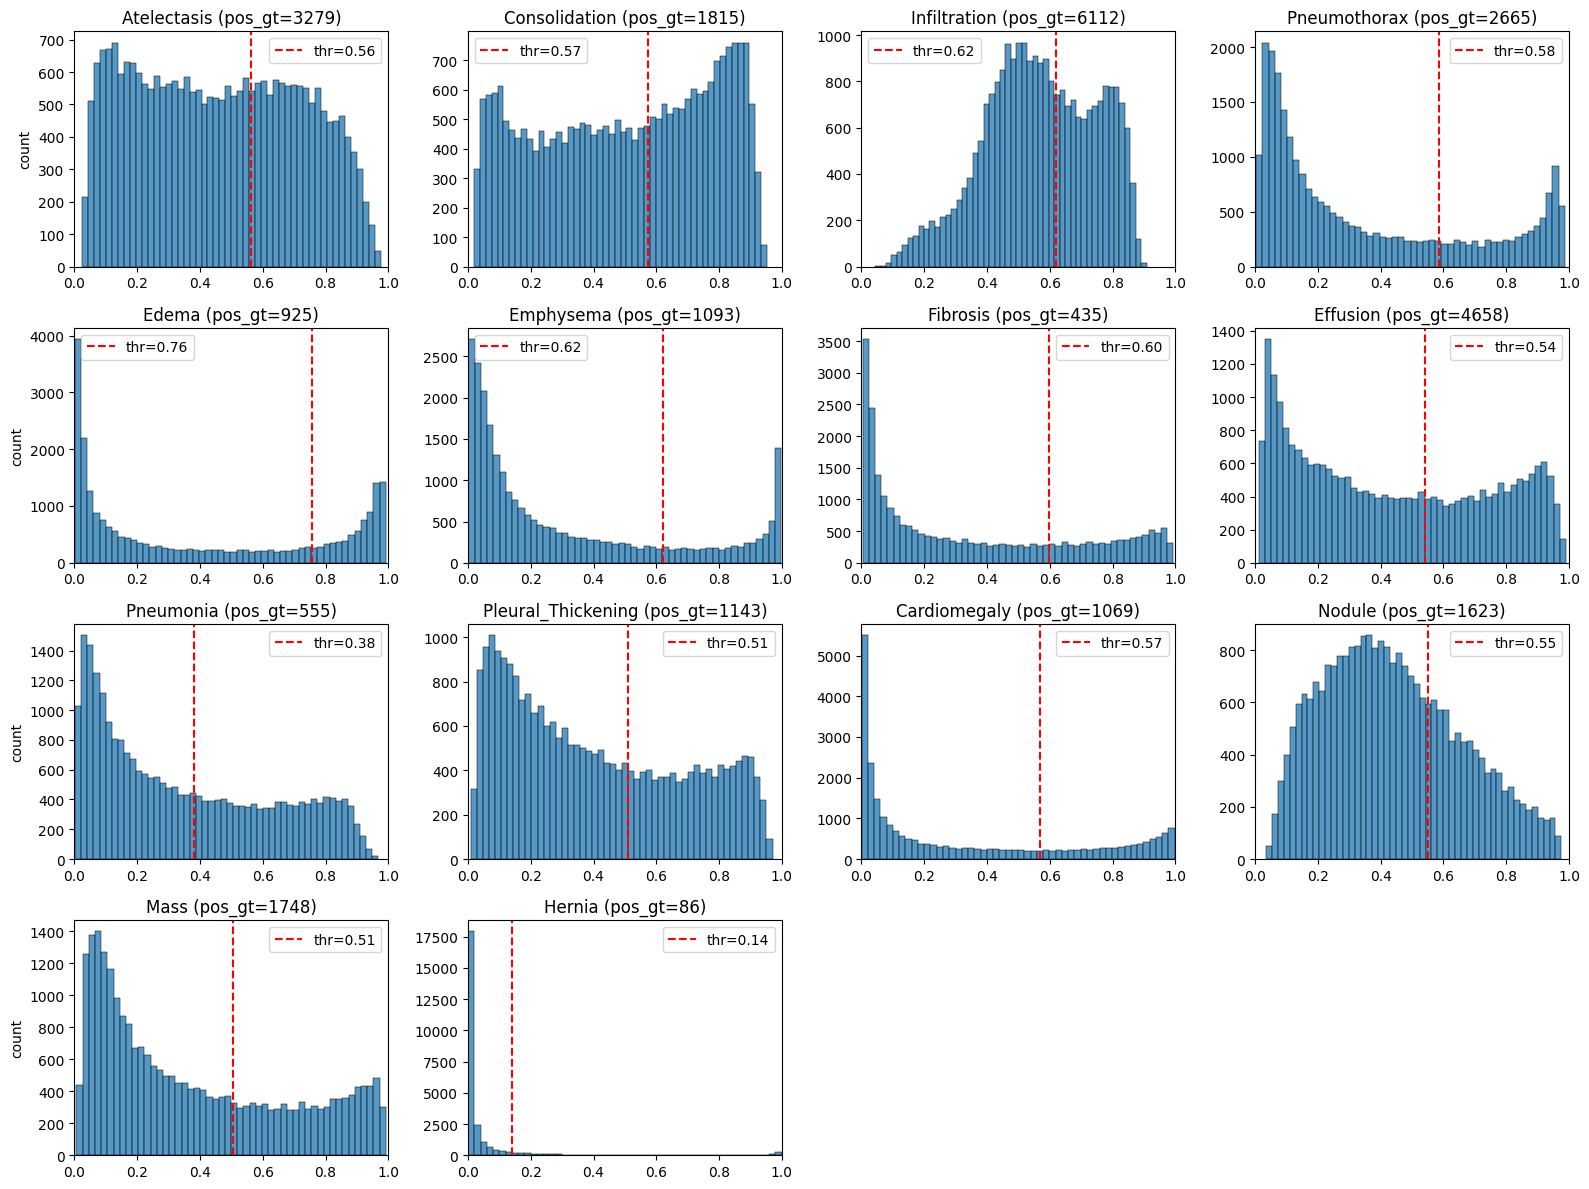


Ejemplos (hasta 20) de indices con GT>0 pero modelo no predijo nada (no_pred): 488 encontrados.
[  15   51  155  224  250  402  429  517  532  534  567  705  828  910
  932  969  970 1009 1063 1093]
No tienes 'image_names' en memoria


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# ---------------------------
# CONFIG (ajusta si querés)
# ---------------------------
USE_OPTIMAL_THRESHOLDS = True   # calcula thresholds por Youden; si False usa FIXED_THRESHOLD
FIXED_THRESHOLD = 0.5
PLOT_NCOLS = 4                  # columnas para grid de histogramas
FIGSIZE_PER_PLOT = (4,3)
SAVE_PLOTS = True
OUT_PREFIX = "eval_outputs"     # prefix para archivos guardados
# ---------------------------

# Asegurar arrays numpy
probs = np.array(all_outputs, dtype=float)   # puede ser logits o probs
labels = np.array(all_labels, dtype=int)     # 0/1

# Convertir logits->probs si hace falta (valores fuera [0,1])
if probs.min() < 0.0 or probs.max() > 1.0:
    probs = 1.0 / (1.0 + np.exp(-probs))

N, C = probs.shape
try:
    class_names
except NameError:
    class_names = [f"class_{i}" for i in range(C)]

# ---------------------------
# Calcular thresholds por clase (Youden / ROC) o usar fijo
# ---------------------------
thresholds = np.full(C, FIXED_THRESHOLD, dtype=float)
if USE_OPTIMAL_THRESHOLDS:
    for i in range(C):
        y_true = labels[:, i]
        y_prob = probs[:, i]
        if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):  # necesita positivos y negativos
            fpr, tpr, thr = roc_curve(y_true, y_prob)
            youden = tpr - fpr
            best_idx = np.nanargmax(youden)
            thresholds[i] = float(thr[best_idx])
        else:
            thresholds[i] = FIXED_THRESHOLD  # fallback

print("Thresholds por clase (usados):")
for i, t in enumerate(thresholds):
    print(f" - {class_names[i]}: {t:.3f}")

# ---------------------------
# Predicciones binarias usando thresholds por clase
# ---------------------------
preds = (probs >= thresholds[np.newaxis, :]).astype(int)

# ---------------------------
# Estadísticas por sample (global)
# ---------------------------
# muestras sin labels reales (normales)
no_true_mask = (labels.sum(axis=1) == 0)
num_no_true = int(no_true_mask.sum())
pct_no_true = num_no_true / N * 100.0

# muestras en las que modelo no predijo nada (todas 0)
no_pred_mask = (preds.sum(axis=1) == 0)
num_no_pred = int(no_pred_mask.sum())
pct_no_pred = num_no_pred / N * 100.0

# de las imágenes enfermas, cuántas quedaron sin predicción (miss rate)
gt_positive_mask = ~no_true_mask
miss_on_sick_mask = no_pred_mask & gt_positive_mask
num_miss_on_sick = int(miss_on_sick_mask.sum())
pct_miss_on_sick = (num_miss_on_sick / max(1, gt_positive_mask.sum())) * 100.0

print("\nResumen global de samples:")
print(f" - Total samples: {N}")
print(f" - Samples sin patología en GT (all zeros): {num_no_true} ({pct_no_true:.2f}%)")
print(f" - Samples donde modelo no predijo ninguna clase: {num_no_pred} ({pct_no_pred:.2f}%)")
print(f" - Entre imágenes enfermas, misses (no_pred & tiene GT>0): {num_miss_on_sick} ({pct_miss_on_sick:.2f}%)")

# ---------------------------
# Estadísticas por clase y confusion matrices
# ---------------------------
rows = []
for i in range(C):
    y_true = labels[:, i]
    y_pred = preds[:, i]
    # confusion matrix (tn, fp, fn, tp)
    if np.unique(y_true).size == 1:
        # si solo hay un tipo (todos 0 o todos 1), confusion_matrix puede comportarse raro
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
    else:
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    # miss rate para esta clase: de los positivos reales, cuántos no predijimos
    pos_total = int(y_true.sum())
    miss_rate = (fn / pos_total) * 100.0 if pos_total > 0 else np.nan

    rows.append({
        "class": class_names[i],
        "threshold": float(thresholds[i]),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "positives_gt": pos_total,
        "precision": float(prec), "recall": float(rec), "f1": float(f1), "accuracy": float(acc),
        "miss_rate_pct": miss_rate
    })

per_class_summary = pd.DataFrame(rows).sort_values(by='miss_rate_pct', ascending=False)
display(per_class_summary)
per_class_summary.to_csv(f"{OUT_PREFIX}_per_class_summary.csv", index=False)
print(f"\nPer-class summary saved to {OUT_PREFIX}_per_class_summary.csv")

# ---------------------------
# Histogramas de probabilidades por clase
# ---------------------------
ncols = PLOT_NCOLS
nrows = int(np.ceil(C / ncols))
fig_w = ncols * FIGSIZE_PER_PLOT[0]
fig_h = nrows * FIGSIZE_PER_PLOT[1]
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
axes = axes.flatten()

for i in range(C):
    ax = axes[i]
    sns.histplot(probs[:, i], bins=50, kde=False, stat='count', ax=ax)
    ax.axvline(thresholds[i], color='red', linestyle='--', label=f"thr={thresholds[i]:.2f}")
    ax.set_title(f"{class_names[i]} (pos_gt={int(labels[:,i].sum())})")
    ax.set_xlim(0,1)
    if i % ncols == 0:
        ax.set_ylabel("count")
    else:
        ax.set_ylabel("")
    ax.legend()

# ocultar ejes extras
for j in range(C, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
if SAVE_PLOTS:
    fname = f"{OUT_PREFIX}_prob_histograms.png"
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    print(f"Saved histograms to {fname}")
plt.show()

# ---------------------------
# Mostrar ejemplos (indices) de imágenes no detectadas pero con GT > 0
# ---------------------------
indices_missed = np.where(miss_on_sick_mask)[0]
print(f"\nEjemplos (hasta 20) de indices con GT>0 pero modelo no predijo nada (no_pred): {len(indices_missed)} encontrados.")
print(indices_missed[:20])

try:
    image_names  # lista con length N en el mismo orden que all_outputs/all_labels
    sample_df = pd.DataFrame({
        "idx": np.arange(N),
        "image_name": image_names,
        "num_gt_labels": labels.sum(axis=1),
        "num_pred_labels": preds.sum(axis=1),
        "no_pred": (preds.sum(axis=1) == 0),
        "miss_on_sick": miss_on_sick_mask
    })
    sample_df.to_csv(f"{OUT_PREFIX}_sample_summary_with_names.csv", index=False)
    print(f"Saved sample summary with image names to {OUT_PREFIX}_sample_summary_with_names.csv")
except NameError:
    print("No tienes 'image_names' en memoria")

In [30]:
!pip install opencv-python matplotlib --quiet

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# ----------------- utilidades -----------------
def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def tensor_to_image_np(tensor):
    """Convierte tensor 1xC x H x W (valores en [0,1] o normalize inv) a HxWx3 float [0,1]."""
    t = tensor.detach().cpu().squeeze(0).numpy()
    if t.shape[0] == 1:
        img = np.repeat(t, 3, axis=0)
    else:
        img = t
    img = img.transpose(1,2,0)
    # si valores fuera [0,1], recortamos
    img = np.clip(img, 0, 1)
    return img

def overlay_heatmap_on_image(img_np, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """img_np: HxWx3 [0,1], heatmap: HxW [0,1]"""
    hm = (255 * heatmap).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm, colormap)[:,:,::-1] / 255.0  # BGR->RGB
    overlay = (1-alpha) * img_np + alpha * hm_color
    overlay = np.clip(overlay, 0, 1)
    return overlay

# ----------------- Grad-CAM -----------------
import torch.nn as nn

def find_last_conv_name(model):
    """Intenta hallar el nombre del último módulo Conv2d en el modelo."""
    last_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
    return last_name

class GradCAM:
    def __init__(self, model, target_layer_name=None):
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        if target_layer_name is None:
            target_layer_name = find_last_conv_name(model)
            if target_layer_name is None:
                raise ValueError("No se encontró capa Conv2d automática; pasa target_layer_name manualmente.")
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradients = None
        # registrar hooks
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                module.register_forward_hook(self._forward_hook)
                # NOTE: register_backward_hook es legacy; usamos register_full_backward_hook si disponible
                try:
                    module.register_full_backward_hook(self._backward_hook)
                except AttributeError:
                    module.register_backward_hook(self._backward_hook)
                break
        else:
            raise ValueError(f"target layer {target_layer_name} no encontrado en el modelo.")

    def _forward_hook(self, module, input, output):
        # guarda activations (detach)
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0] corresponde al gradiente del output del módulo
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx):
        """
        input_tensor: 1xC x H x W (ya en device)
        class_idx: índice de la clase objetivo (int)
        devuelve: cam (HxW normalizado 0-1), logits (1xC numpy)
        """
        self.model.zero_grad()
        self.activations = None
        self.gradients = None

        logits = self.model(input_tensor)  # salida logits (1 x C)
        if logits.ndim == 1:
            logits = logits.unsqueeze(0)
        score = logits[0, class_idx]
        # backward
        score.backward(retain_graph=True)
        if self.activations is None or self.gradients is None:
            raise RuntimeError("Hooks no capturaron activaciones o gradientes. Asegurate que target_layer es correcta y que forward pasó por allí.")

        grads = self.gradients[0]   # C x h x w
        acts = self.activations[0]  # C x h x w

        # global average pooling de gradientes por canal
        weights = torch.mean(grads.view(grads.shape[0], -1), dim=1)  # C
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(self.device)  # h x w

        for i, w in enumerate(weights):
            cam += w * acts[i]
        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        # normalizar
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()
        # redimensionar al tamaño de entrada
        H = input_tensor.shape[-2]
        W = input_tensor.shape[-1]
        cam = cv2.resize(cam, (W, H))
        return cam, logits.detach().cpu().numpy()
# ------------------ WRAPPER para usar GradCAM con modelo que pide (images, meta) ------------------
import torch
import torch.nn as nn

class ModelForGradCAM(nn.Module):
    """
    Wrapper que adapta un modelo con forward(images, meta) a forward(images).
    Crea un meta por defecto (ceros) del tamaño correcto.
    """
    def __init__(self, orig_model, meta_dim, meta_default=None):
        super().__init__()
        self.orig = orig_model
        self.meta_dim = meta_dim
        # meta_default puede ser None (usa ceros) o un tensor 1 x meta_dim (se replicará al batch)
        if meta_default is not None:
            if isinstance(meta_default, np.ndarray):
                meta_default = torch.tensor(meta_default, dtype=torch.float32)
        self.meta_default = meta_default

    def forward(self, x):
        # x: B x C x H x W
        batch = x.shape[0]
        device = x.device
        if self.meta_default is None:
            meta = torch.zeros((batch, self.meta_dim), device=device, dtype=torch.float32)
        else:
            # replicar la meta_default al batch
            md = self.meta_default.to(device).detach()
            if md.dim() == 1:
                md = md.unsqueeze(0)
            meta = md.expand(batch, -1).to(device)
        return self.orig(x, meta)

# ------------------ detectar meta_dim automáticamente ------------------
# intentamos obtener la dimensión de meta desde train_loader (primer batch)
try:
    sample_images, sample_meta, sample_labels = next(iter(train_loader))
    meta_dim = sample_meta.shape[1]
    print("Detectado meta_dim desde train_loader:", meta_dim)
except Exception as e:
    # fallback: ofrecer que el usuario especifique meta_dim manualmente
    raise RuntimeError("No pude obtener meta_dim desde train_loader automáticamente. "
                       "Asegurate de que train_loader esté definido y no vacío. Error: " + str(e))

# ------------------ crear wrapper y GradCAM usando el wrapper ------------------
# usar el modelo ya entrenado (o el actual en memoria)
model.eval()
wrapped_model = ModelForGradCAM(model, meta_dim=meta_dim, meta_default=None).to(device)
wrapped_model.eval()

# si find_last_conv_name no encuentra la capa correcta, imprime módulos para elegir
last_conv = find_last_conv_name(wrapped_model)
print("Last conv found (auto):", last_conv)
if last_conv is None:
    print("Listado de módulos del modelo (elige manualmente el nombre de la capa conv objetivo si es necesario):")
    for name, module in wrapped_model.named_modules():
        print(name, type(module))

# crear instancia de GradCAM apuntando a la capa detectada (o pasa target_layer_name string)
gradcam = GradCAM(wrapped_model, target_layer_name=last_conv)  # o GradCAM(wrapped_model, target_layer_name="backbone.conv2")
print("GradCAM listo usando wrapper. target_layer_name =", last_conv)
# ---------------------------------------------------------------------------------------------------


Detectado meta_dim desde train_loader: 3
Last conv found (auto): orig.cnn.0.denseblock4.denselayer16.conv2
GradCAM listo usando wrapper. target_layer_name = orig.cnn.0.denseblock4.denselayer16.conv2


In [31]:
from tqdm import tqdm
import numpy as np

def save_gradcam_examples(model, dataloader, class_names, out_dir="gradcam_outputs",
                          target_layer_name=None, max_per_class=20, device='cuda'):
    """
    Recorre el dataloader (sin barajar) y genera Grad-CAMs por clase.
    Guarda ejemplos separados por clase y por tipo: TP/FP/FN/TN.
    """
    ensure_dir(out_dir)
    gradcam = GradCAM(model, target_layer_name=target_layer_name)
    model.eval()
    saved_counts = {c: {"TP":0,"FP":0,"FN":0,"TN":0} for c in class_names}
    # iterar
    idx_global = 0
    for images, meta, labels in tqdm(dataloader, desc="GradCAM eval"):
        # images: batch x C x H x W, labels: batch x C
        bs = images.size(0)
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model(images, meta.to(device, non_blocking=True))
            probs = torch.sigmoid(logits).cpu().numpy()
        labels_np = labels.cpu().numpy()

        for b in range(bs):
            img_tensor = images[b:b+1]  # 1xC x H x W (on device)
            img_np = tensor_to_image_np(img_tensor)  # HxWx3 in [0,1]
            probs_b = probs[b]   # C
            labels_b = labels_np[b]  # C

            for i, cls in enumerate(class_names):
                if all(v >= max_per_class for v in saved_counts[cls].values()):
                    continue  # ya guardamos suficientes para esa clase
                prob = float(probs_b[i])
                pred = 1 if prob >= 0.5 else 0  # aquí usamos 0.5; opcional: usar umbral por clase
                truth = int(labels_b[i])

                # determinar tipo
                if truth == 1 and pred == 1:
                    tag = "TP"
                elif truth == 0 and pred == 1:
                    tag = "FP"
                elif truth == 1 and pred == 0:
                    tag = "FN"
                else:
                    tag = "TN"

                # guardamos solo algunas categorías (por ejemplo TP/FP/FN)
                # cambiar si querés incluir TN
                if saved_counts[cls][tag] >= max_per_class:
                    continue

                # calcular gradcam (solo para clases con pred=1 o truth=1 o si querés siempre)
                try:
                    cam, logits_np = gradcam(img_tensor.to(device), i)
                except Exception as e:
                    print("GradCAM failed for idx", idx_global, "class", cls, "err:", e)
                    continue

                overlay = overlay_heatmap_on_image(img_np, cam, alpha=0.5)
                # guardar imagenes (original, cam, overlay)
                cls_dir = Path(out_dir) / f"{cls}"
                ensure_dir(cls_dir)
                fname_base = f"idx{idx_global:06d}_{tag}_p{prob:.3f}"
                # original
                orig_path = cls_dir / (fname_base + "_orig.png")
                plt.imsave(str(orig_path), img_np)
                # cam gray
                cam_path = cls_dir / (fname_base + "_cam.png")
                plt.imsave(str(cam_path), cam, cmap='jet')
                # overlay
                ov_path = cls_dir / (fname_base + "_overlay.png")
                plt.imsave(str(ov_path), overlay)

                saved_counts[cls][tag] += 1

            idx_global += 1

        # si ya juntamos suficientes para todas las clases, podemos romper
        done = all(all(v >= max_per_class for v in saved_counts[c].values()) for c in class_names)
        if done:
            break

    print("Saved counts:", saved_counts)
    return saved_counts

# EJEMPLO de uso:
# class_names debe ser lista de strings en el orden de tus clases
# save_gradcam_examples(model, test_loader, class_names, out_dir="gradcam_outputs", target_layer_name=None, max_per_class=10, device=device)


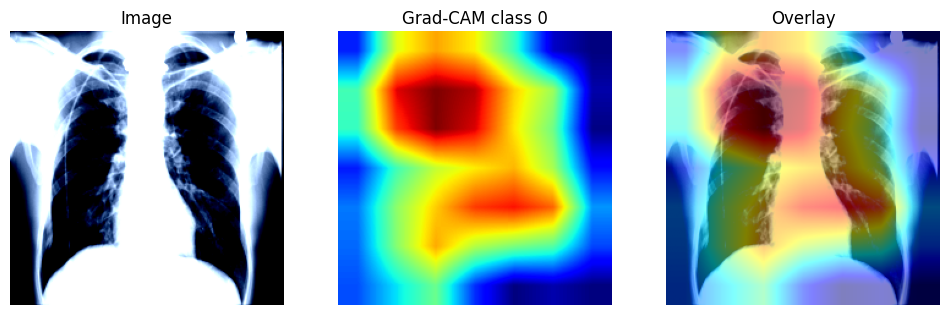

Logits (all classes): [-3.357403  -3.1526    -1.2825674 -4.8122344 -3.866018  -3.436516
 -2.4702032 -3.9813452 -1.930629  -1.7758228 -7.511555  -0.7200432
 -1.400051  -4.654122 ]
Probabilidad clase 0: 0.0337


In [32]:
# ------------------ Ejemplo de uso: generar Grad-CAM para 1 imagen ------------------
import matplotlib.pyplot as plt

# tomar 1 batch del val_loader
images, meta, labels = next(iter(val_loader))
# elegir el primer sample del batch
img_tensor = images[0:1].to(device)        # 1 x C x H x W
true_labels = labels[0].cpu().numpy()
# elegir clase objetivo (ej: la primera clase positiva si existe, si no elegir 0)
if true_labels.sum() > 0:
    class_idx = int(np.where(true_labels == 1)[0][0])
else:
    class_idx = 0

# calcular cam (usa el wrapper internamente)
cam, logits = gradcam(img_tensor, class_idx)

# convertir tensor a imagen numpy y superponer
img_np = tensor_to_image_np(img_tensor)    # HxWx3 [0,1]
overlay = overlay_heatmap_on_image(img_np, cam, alpha=0.5)

# mostrar resultados
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_np); plt.axis('off')
plt.subplot(1,3,2); plt.title(f"Grad-CAM class {class_idx}"); plt.imshow(cam, cmap='jet'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis('off')
plt.show()

print("Logits (all classes):", logits[0])
print("Probabilidad clase {}: {:.4f}".format(class_idx, 1/(1+np.exp(-logits[0,class_idx]))))
# -----------------------------------------------------------------------------------------


Usando target layer: orig.cnn.0.denseblock4.denselayer16.conv2


<Figure size 1500x5600 with 0 Axes>

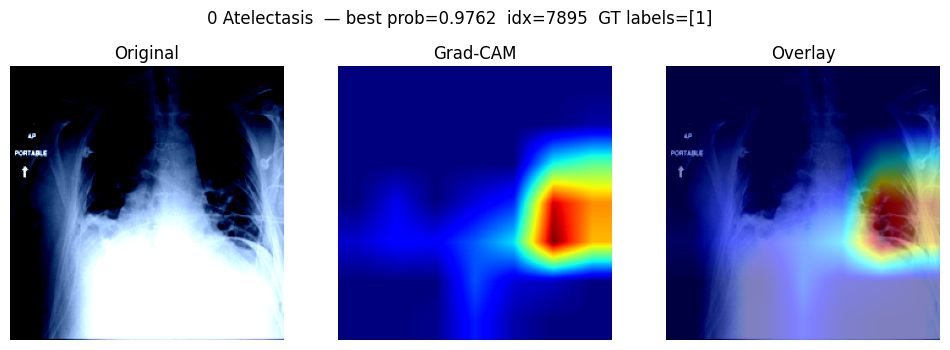

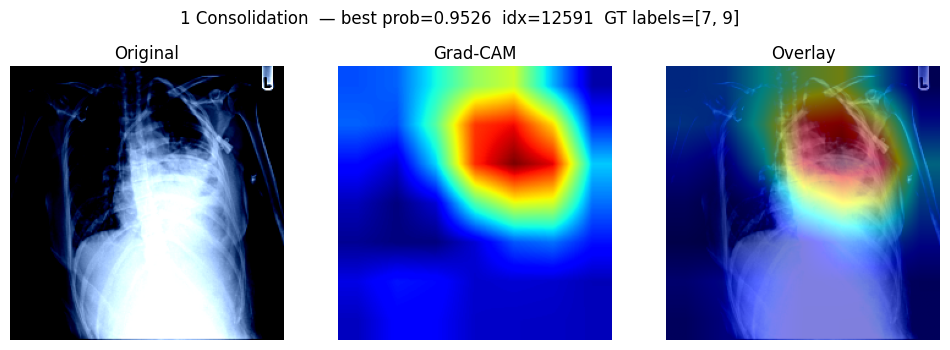

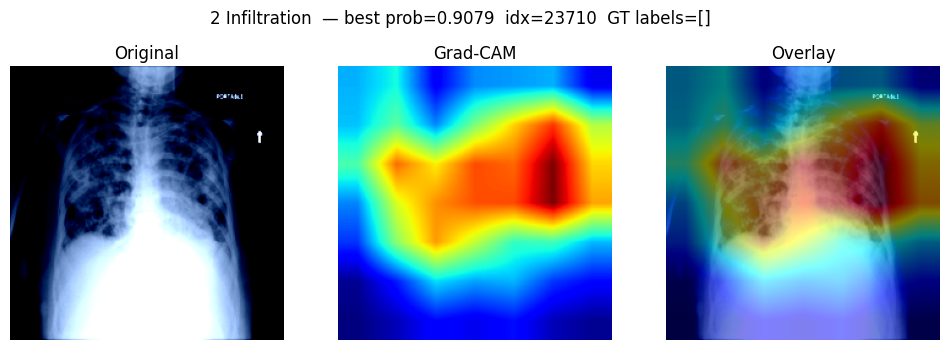

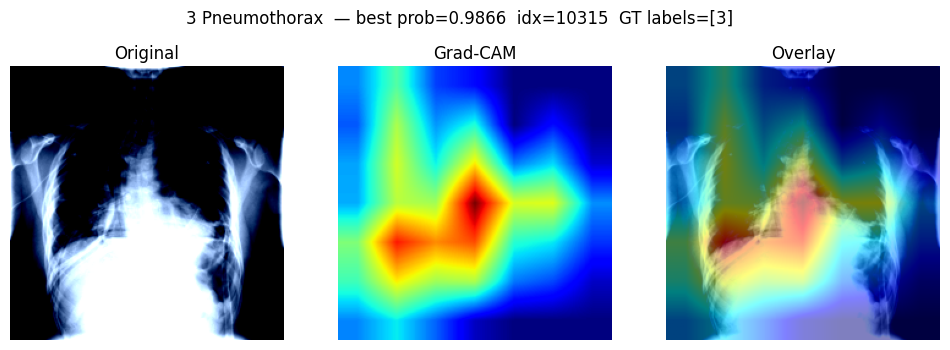

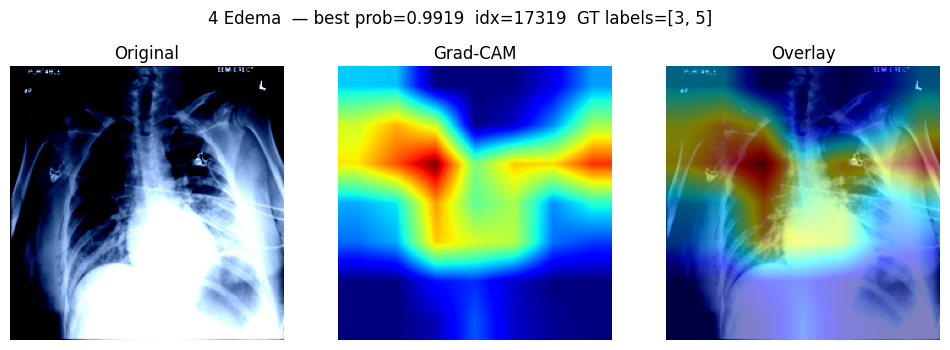

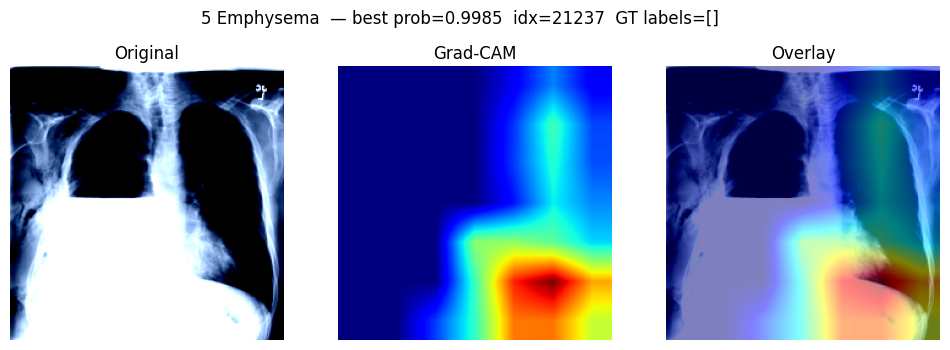

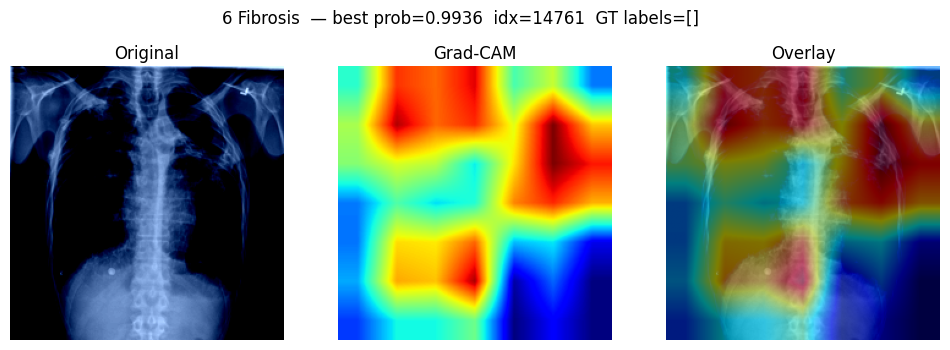

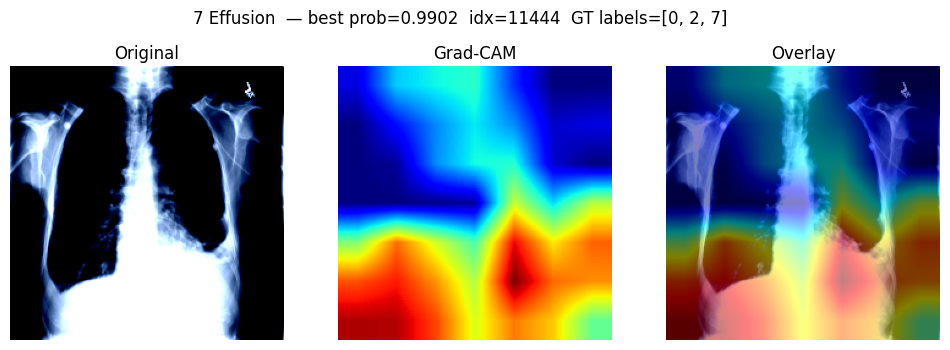

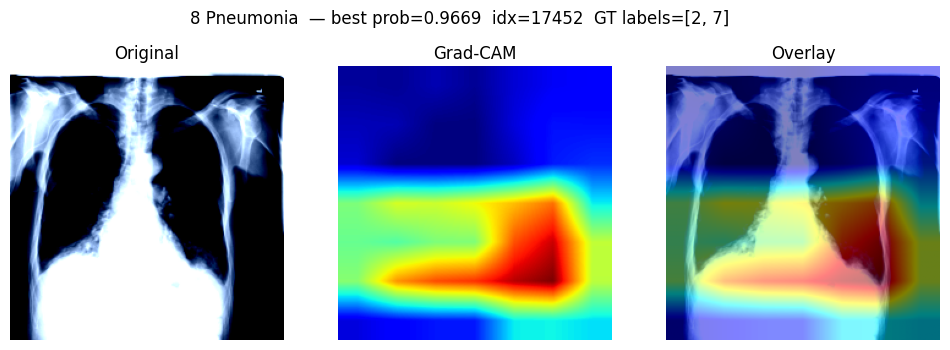

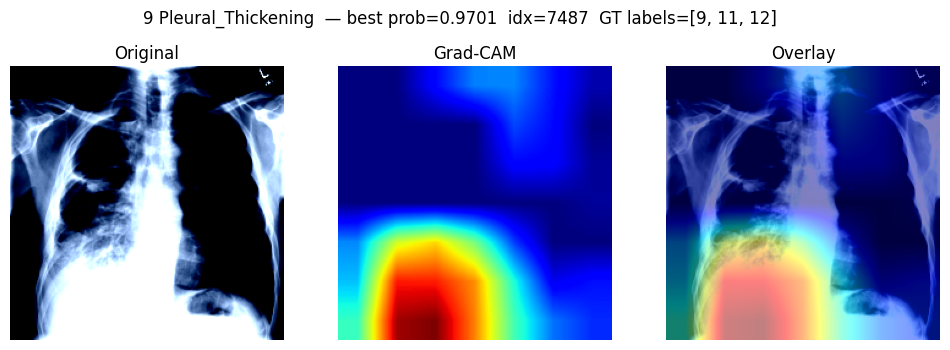

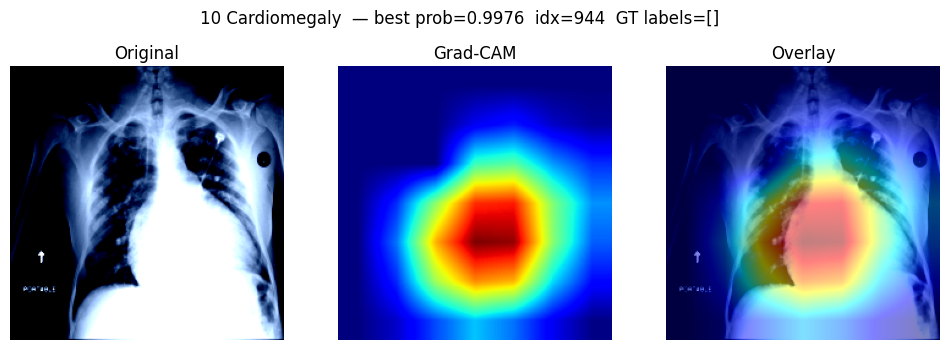

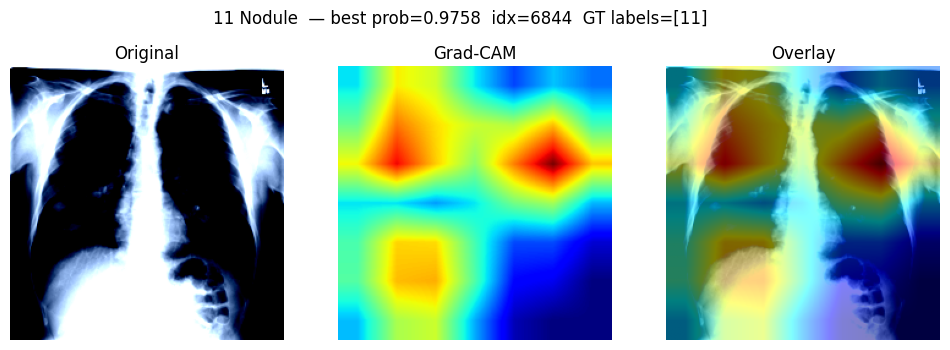

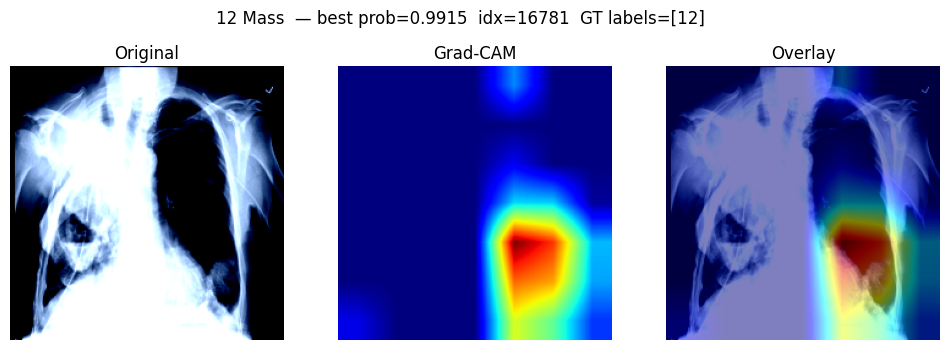

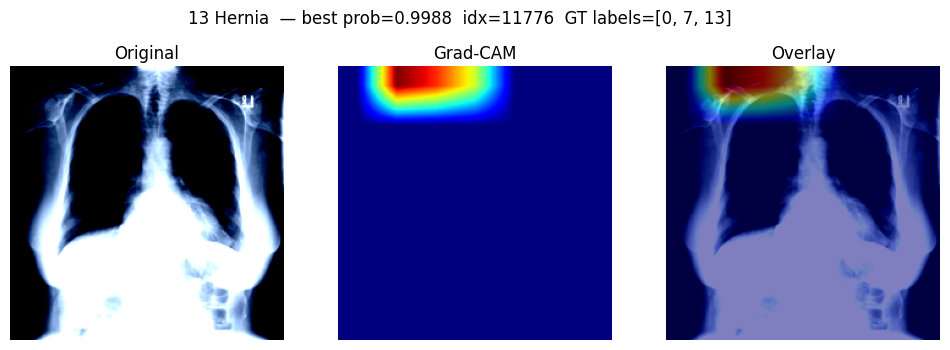

Guardadas imágenes en /home/project_cv_um/ProyectoCNN/gradcam_best_per_class


In [33]:
# ---------------- CELDA: Mostrar para cada clase la imagen con mayor score + Grad-CAM ----------------
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
ensure_dir = lambda p: Path(p).mkdir(parents=True, exist_ok=True)

# Config
DATA_LOADER = test_loader    # o val_loader
OUT_DIR = Path("gradcam_best_per_class")
ensure_dir(OUT_DIR)
MAX_SHOW = None  # si quieres limitar número de clases a mostrar, p.ej. 6; None = todas

# Verificaciones mínimas
assert 'model' in globals(), "Define 'model' antes de ejecutar esto."
assert DATA_LOADER is not None, "Define test_loader o val_loader y asignalo a DATA_LOADER."
try:
    class_names
except NameError:
    class_names = [f"class_{i}" for i in range(num_classes)]

C = len(class_names)
if MAX_SHOW is None:
    MAX_SHOW = C

# ------------------ Preparar wrapper para GradCAM ------------------
# intentar detectar meta_dim desde el dataloader
try:
    sample_batch = next(iter(DATA_LOADER))
    _, sample_meta, _ = sample_batch
    meta_dim = sample_meta.shape[1]
except Exception as e:
    raise RuntimeError("No pude detectar meta_dim automáticamente desde DATA_LOADER. Asegurate que DATA_LOADER no esté vacío.") from e

# crear wrapper si no existe
try:
    wrapped_model  # if already created
except NameError:
    wrapped_model = ModelForGradCAM(model, meta_dim=meta_dim, meta_default=None).to(device)
    wrapped_model.eval()

# crear GradCAM con la última conv detectada (puede ajustarse manualmente)
last_conv = find_last_conv_name(wrapped_model)
if last_conv is None:
    raise RuntimeError("No encontré una capa Conv2d en wrapped_model; revisá find_last_conv_name o pasa target_layer_name manualmente.")
gradcam = GradCAM(wrapped_model, target_layer_name=last_conv)
print("Usando target layer:", last_conv)

# ------------------ Recorrer loader y seleccionar mejores imágenes por clase ------------------
best = []
for i in range(C):
    best.append({"prob": -1.0, "img_tensor": None, "meta": None, "logits": None, "label": None, "idx": None})

idx_global = 0
wrapped_model.eval()
with torch.no_grad():
    for images, meta, labels in DATA_LOADER:
        bs = images.size(0)
        images_gpu = images.to(device, non_blocking=True)
        meta_gpu = meta.to(device, non_blocking=True)
        logits = model(images_gpu, meta_gpu)  # usar model directamente para obtener logits
        probs = torch.sigmoid(logits).cpu().numpy()  # N x C
        logits_cpu = logits.cpu().numpy()
        labels_np = labels.cpu().numpy()
        # recorrer batch
        for b in range(bs):
            for cls in range(C):
                p = float(probs[b, cls])
                if p > best[cls]["prob"]:
                    # guardar copia en CPU para no retener GPU memoria
                    best[cls]["prob"] = p
                    best[cls]["img_tensor"] = images[b:b+1].cpu().detach()   # 1xC x H x W on CPU
                    best[cls]["meta"] = meta[b:b+1].cpu().detach()
                    best[cls]["logits"] = logits_cpu[b].copy()
                    best[cls]["label"] = labels_np[b].copy()
                    best[cls]["idx"] = idx_global + b
        idx_global += bs

# ------------------ Mostrar Grad-CAMs para cada clase (la mejor encontrada) ------------------
n_show = min(C, MAX_SHOW)
ncols = 3
nrows = int(np.ceil(n_show / 1))  # uno por fila, cada fila mostrará 3 subplots (img, cam, overlay)
plt.figure(figsize=(ncols * 5, n_show * 4))

for i in range(n_show):
    info = best[i]
    cls_name = class_names[i]
    if info["img_tensor"] is None:
        print(f"Clase {cls_name}: no se encontraron imágenes en el loader.")
        continue

    img_tensor_cpu = info["img_tensor"]  # 1xC x H x W (CPU)
    prob = info["prob"]
    idx = info["idx"]
    label = info["label"]

    # mover a device para gradcam (wrapper espera imagen only)
    input_tensor = img_tensor_cpu.to(device)

    # calcular Grad-CAM (esto hace backward internamente)
    try:
        cam, logits_out = gradcam(input_tensor, i)
    except Exception as e:
        print(f"GradCAM failed for class {cls_name} idx {idx} err:", e)
        continue

    # preparar imagenes para mostrar
    img_np = tensor_to_image_np(img_tensor_cpu)  # HxWx3 [0,1]
    overlay = overlay_heatmap_on_image(img_np, cam, alpha=0.5)

    # mostrar: original, cam, overlay
    plt.figure(figsize=(12,4))
    plt.suptitle(f"{i} {cls_name}  — best prob={prob:.4f}  idx={idx}  GT labels={np.where(label==1)[0].tolist()}")
    plt.subplot(1,3,1)
    plt.imshow(img_np); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(cam, cmap='jet'); plt.title("Grad-CAM"); plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')

    # guardar en disco
    cls_dir = OUT_DIR / f"{i}_{cls_name.replace('/','_')}"
    cls_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(cls_dir / f"best_idx{idx}_prob{prob:.4f}.png", bbox_inches='tight', dpi=200)
    plt.show()

print(f"Guardadas imágenes en {OUT_DIR.resolve()}")
# ---------------- FIN ----------------


In [40]:

!pip install torchinfo --quiet
from torchinfo import summary
from CNNTransformerFusion import CNNTransformerFusion

model = CNNTransformerFusion(num_classes=num_classes).to(device)

summary(model, input_data=[torch.randn(1,3,224,224).to(device),
                           torch.randn(1,meta_dim).to(device)])
!pip install torchviz graphviz --quiet
from torchviz import make_dot

images = torch.randn(1,3,224,224).to(device)
meta = torch.randn(1,meta_dim).to(device)

model = CNNTransformerFusion(num_classes=num_classes).to(device)
output = model(images, meta)


dot = make_dot(output, params=dict(model.named_parameters()))

dot.format = 'png'
dot.render('cnntransformer_architecture')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.802621 to fit


'cnntransformer_architecture.png'